In [1]:
import numpy as np
import os
import re
import pydicom
import cv2
import random
import imageio
import scipy.ndimage
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPool3D
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

print('Import Scussessful!')

Import Scussessful!


In [2]:
X = np.load('./data/X3.npy')
y= np.load('./data/y3.npy')
X = X.transpose((0, 4, 1, 2, 3))
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.6 * len(dataset)) 
val_size = int(0.2 * len(dataset))  
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('Data Splitting Successful!')

Data Splitting Successful!


In [3]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3370, 1, 20, 100, 80)
Shape of y: (3370, 4)


Epoch 1/100, Train Accuracy: 27.448071216617212%, Val Accuracy: 31.602373887240358%
Epoch 2/100, Train Accuracy: 29.27794263105836%, Val Accuracy: 28.486646884272997%
Epoch 3/100, Train Accuracy: 31.107814045499506%, Val Accuracy: 34.27299703264095%
Epoch 4/100, Train Accuracy: 37.78437190900099%, Val Accuracy: 42.58160237388724%
Epoch 5/100, Train Accuracy: 46.48862512363996%, Val Accuracy: 49.40652818991098%
Epoch 6/100, Train Accuracy: 53.560830860534125%, Val Accuracy: 52.07715133531157%
Epoch 7/100, Train Accuracy: 60.23738872403561%, Val Accuracy: 54.3026706231454%
Epoch 8/100, Train Accuracy: 63.254203758654796%, Val Accuracy: 54.74777448071217%
Epoch 9/100, Train Accuracy: 68.39762611275964%, Val Accuracy: 59.64391691394659%
Epoch 10/100, Train Accuracy: 69.8318496538081%, Val Accuracy: 62.46290801186944%
Epoch 11/100, Train Accuracy: 72.55192878338279%, Val Accuracy: 63.64985163204748%
Epoch 12/100, Train Accuracy: 74.33234421364985%, Val Accuracy: 63.50148367952522%
Epoch 13/

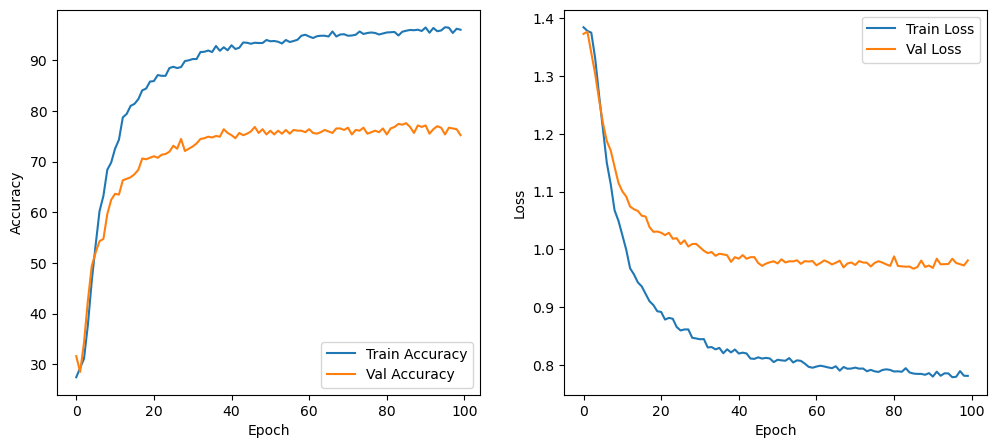

Test Accuracy: 75.22255192878339%


In [4]:
class BasicModel(nn.Module):
    def __init__(self, input_shape):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv3d(1, 128, kernel_size=(10, 3, 3), stride=1)
        self.conv2 = nn.Conv3d(128,32, kernel_size=(3, 3, 3), stride=1) 
        self.bn1 = nn.BatchNorm3d(32)
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.dropout1 = nn.Dropout(0.5)
        reduced_shape = (((input_shape[0] - 9) - 2) // 2) * (((input_shape[1] - 2) - 2) // 2) * (((input_shape[2] - 2) - 2) // 2)
        self.fc1 = nn.Linear(32 * reduced_shape,128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
input_shape = (20, 100, 80)
learning_rate = 0.0001
batch_size = 8
epochs = 100

model = BasicModel(input_shape)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
model = model.cuda()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for data, target in train_loader:
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, torch.max(target, 1)[1])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        _, target_indices = torch.max(target, 1)
        train_total += target.size(0)
        train_correct += (predicted == target_indices).sum().item()
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            loss = criterion(output, torch.max(target, 1)[1])
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            _, target_indices = torch.max(target, 1)
            total += target.size(0)
            correct += (predicted == target_indices).sum().item()
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy}%, Val Accuracy: {val_accuracy}%")
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
use_cuda = torch.cuda.is_available()
model = model.cuda()
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader: 
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

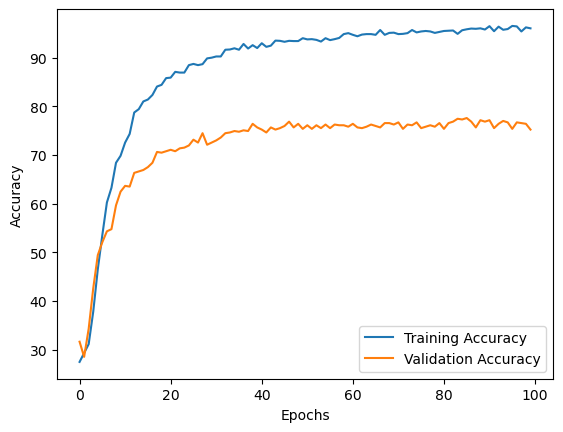

In [5]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

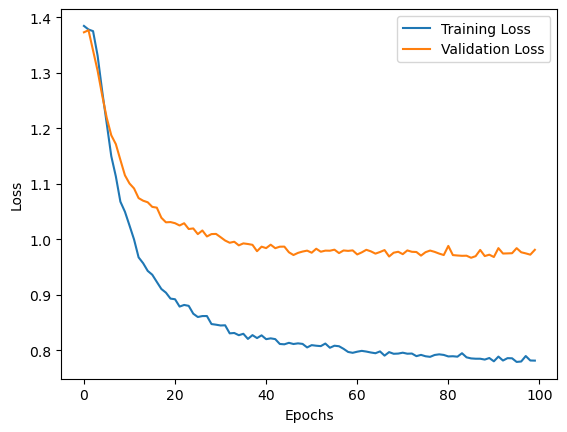

In [6]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 76.70623145400593%
Confusion Matrix:
[[152  16  16  11]
 [ 11 140   9   6]
 [  8  11 119   9]
 [ 23  16  21 106]]
Precision: 0.7681937253214928
Recall: 0.7677346749635907


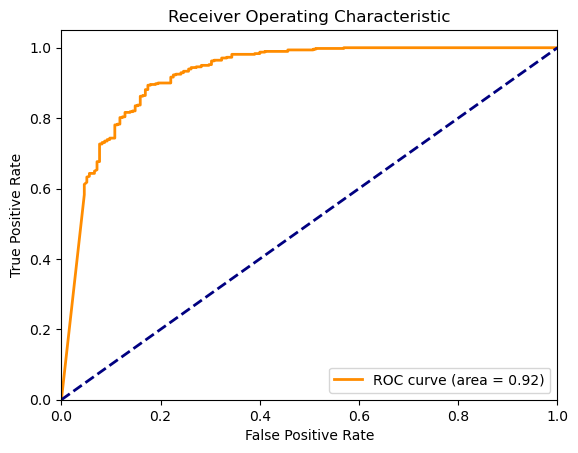

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader: 
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_targets.extend(target_indices.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_mat = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_mat)
precision = precision_score(all_targets, all_predictions, average='macro') 
print(f"Precision: {precision}")
recall = recall_score(all_targets, all_predictions, average='macro') 
print(f"Recall: {recall}")
all_scores = []
all_targets_binary = []
with torch.no_grad():
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        outputs = model(data)
        scores = outputs[:, 1:].max(dim=1).values.cpu().numpy()
        target_indices = torch.argmax(target, dim=1)
        binary_targets = (target_indices != 0).cpu().numpy() 
        all_scores.extend(scores)
        all_targets_binary.extend(binary_targets)
fpr, tpr, _ = roc_curve(all_targets_binary, all_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()